### 引入相關python模組

In [1]:
from mycnn import AlexNet
from mycnn import utils
import tensorflow as tf
import numpy as np

### 使用Keras API來建立Dataset實例

利用Keras API中的`preprocessing`模組的`image_dataset_from_directory`  
用此函數來建立貓狗的資料集，此函數將會回傳`tf.data.Dataset`的實例  
接著使用`map`函式來重新縮放(正規化)資料區間至 [0, 1]

#### tf.keras.preprocessing.image_dataset_from_directory

```
參數名稱            型態    說明
directory        : str   : 資料路徑 (子資料夾為類別)
image_size       : tuple : 影像大小
batch_size       : int   : 批次大小
label_mode       : str   : 標記模式 "categorical" (註:其他模式需要修改loss函數)
validation_split : float : 分離驗證集的比例
subset           : str   : 選擇訓練集 "training"、驗證集 "validation"
seed             : int   : 亂數種子
```

In [2]:
train_dataset = tf.keras.preprocessing.image_dataset_from_directory(
    r'D:\Datasets\DogsVsCats\train',
    image_size=(227,227),
    batch_size=50,
    label_mode="categorical",
    validation_split=0.2,
    subset="training",
    seed=10
)
train_dataset.map(lambda x, y: (x/255., y))


valid_dataset = tf.keras.preprocessing.image_dataset_from_directory(
    r'D:\Datasets\DogsVsCats\train',
    image_size=(227,227),
    batch_size=50,
    label_mode="categorical",
    validation_split=0.2,
    subset="validation",
    seed=10
)
valid_dataset.map(lambda x, y: (x/255., y))

Found 25000 files belonging to 2 classes.
Using 20000 files for training.
Found 25000 files belonging to 2 classes.
Using 5000 files for validation.


<MapDataset shapes: ((None, 227, 227, 3), (None, 2)), types: (tf.float32, tf.float32)>

### 載入VGG16模型

```
參數名稱       型態    說明
input_shape : tuple : 輸入影像形狀
classes_num : int   : 輸出類別數量
```

In [3]:
alexnet = AlexNet(classes_num=2)
alexnet.summary()

Model: "AlexNet"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
image (InputLayer)           [(None, 227, 227, 3)]     0         
_________________________________________________________________
conv2d (Conv2D)              (None, 55, 55, 96)        34944     
_________________________________________________________________
batch_normalization (BatchNo (None, 55, 55, 96)        384       
_________________________________________________________________
re_lu (ReLU)                 (None, 55, 55, 96)        0         
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 27, 27, 96)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 27, 27, 256)       614656    
_________________________________________________________________
batch_normalization_1 (Batch (None, 27, 27, 256)       1024

### 配置訓練參數

```
參數名稱      型態                         說明
logdir     : str                        : 儲存路徑
epochs     : int                        : 訓練次數
batch_size : int                        : 批次大小 (註:此設定需與image_dataset_from_directory的批次大小一致)
optimizer  : str or tf.keras.optimizers : 優化函數
loss       : str or tf.keras.loss       : 損失函數
metrics    : list                       : 評估函數清單
```

In [4]:
alexnet.setup_training(
    'log_alexnet',
    epochs=20,
    batch_size=50,  # batch size depend on ImageGenerator
    optimizer=tf.keras.optimizers.SGD(learning_rate=0.01, momentum=0.9),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)
alexnet.add_callback(
    tf.keras.callbacks.ReduceLROnPlateau(
        monitor='val_loss', 
        factor=0.8, patience=10,
        min_lr=0.00001,
        verbose=1
    )
)

******************************
Loading last checkpoint...
Start traing from epoch 20
******************************
checkpoint_path : log_alexnet\weights
best_checkpoint : log_alexnet\weights.h5
epochs          : 20
initial_epoch   : 20
batch_size      : 50
optimizer       : <tensorflow.python.keras.optimizer_v2.gradient_descent.SGD object at 0x0000024DCF9E1A88>
loss            : categorical_crossentropy
metrics         : ['accuracy']


### 開始訓練

輸入參數分別為訓練資料集、驗證資料集的實例

In [ ]:
alexnet.train_dataset(train_dataset, valid_dataset)

### 繪製訓練過程曲線

可以用來確認權重是否有收斂的趨勢、檢查是否有過擬合狀況

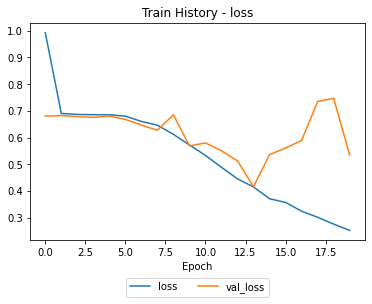

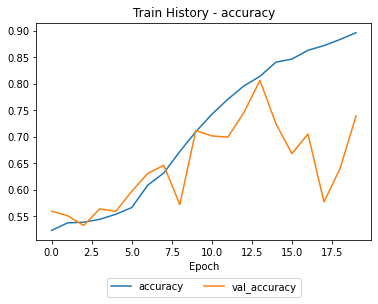

In [5]:
alexnet.show_history(["loss", "accuracy"])

### 使用測試資料來確認模型對於新資料的效能

In [9]:
alexnet.eval_dataset(valid_dataset)

100/100 [==============================] - 19s 153ms/step - loss: 0.5284 - accuracy: 0.7476


[0.5354626178741455, 0.7391999959945679]

### 使用confusion matrix來更進一步確認分類性能

- 預測測試資料的分數 (基於softmax函數計算機率分布)
- 使用`argmax`將分數轉成類別ID
- 輸出分類報告 (印出confusion matrix、分類報告；輸出完整報表)
- 繪製confusion matrix，分為recall、precision

> Note:  
recall: 召回率，在所有GT中，真正預測出TP的指標  
precision: 精確率，在所有預測結果中，真正為TP的指標  
(GT: 真實情況；TP: 正樣本)

Found 25000 files belonging to 2 classes.
Using 5000 files for validation.


100%|██████████| 5000/5000 [00:00<00:00, 452801.90it/s]


[[1202 1291]
 [  13 2494]] 

              precision    recall  f1-score   support

        Cats       0.99      0.48      0.65      2493
        Dogs       0.66      0.99      0.79      2507

    accuracy                           0.74      5000
   macro avg       0.82      0.74      0.72      5000
weighted avg       0.82      0.74      0.72      5000
 



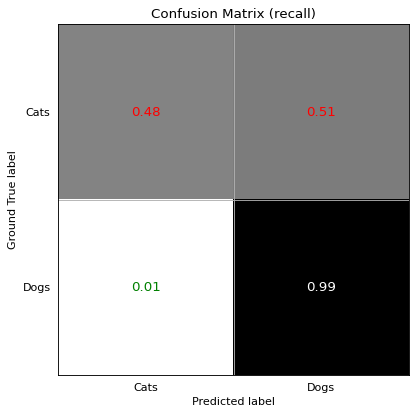

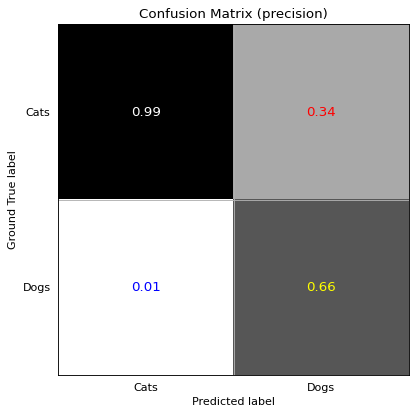

In [5]:
pred_dataset = tf.keras.preprocessing.image_dataset_from_directory(
    r'D:\Datasets\DogsVsCats\train',
    image_size=(227,227),
    batch_size=20,
    label_mode="categorical",
    validation_split=0.2,
    subset="validation",
    seed=10
)
pred_dataset.map(lambda x, y: (x/255., y))

pr_score = None
pr_label = None
gt_label = None
for ind, batch_set in enumerate(pred_dataset):
    batch_im, batch_gt = batch_set
    batch_pr = alexnet.pred(batch_im.numpy())
    if ind == 0:
        pr_score = batch_pr
        pr_label = batch_pr.argmax(axis=-1)
        gt_label = batch_gt.numpy().argmax(axis=-1)
    else:
        pr_score = np.concatenate([pr_score, batch_pr])
        pr_label = np.concatenate([pr_label, batch_pr.argmax(axis=-1)])
        gt_label = np.concatenate([gt_label, batch_gt.numpy().argmax(axis=-1)])

target_names = ["Cats", "Dogs"]

report = utils.export_classification_report(
    gt_label, pr_label, pr_score,
    target_names=target_names,
    logpath=alexnet.logdir
)

cm = report["confusion_matrix"]
cm_precision = cm/cm.sum(axis=0)
cm_recall = cm/cm.sum(axis=1)
utils.plot_confusion_matrix(cm_recall, target_names, alexnet.logdir, title='Confusion Matrix (recall)')
utils.plot_confusion_matrix(cm_precision, target_names, alexnet.logdir, title='Confusion Matrix (precision)')